# DBPedia - Exploratory Data Analysis

<p><b>DBPedia ontology dataset.</b> DBpedia is a crowd-sourced community effort to extract structured
information from Wikipedia [19]. The DBpedia ontology dataset is constructed by picking 14 nonoverlapping classes from DBpedia 2014. From each of these 14 ontology classes, we randomly
choose 40,000 training samples and 5,000 testing samples. The fields we used for this dataset
contain title and abstract of each Wikipedia article.</p>

https://papers.nips.cc/paper/5782-character-level-convolutional-networks-for-text-classification.pdf

## Imports

In [1]:
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

sns.set()

## Input data

In [4]:
!wget -P ../../data https://s3.amazonaws.com/fast-ai-nlp/dbpedia_csv.tgz

with tarfile.open('../../data/dbpedia_csv.tgz') as tar:
    tar.extractall(path="../../data")

--2020-02-13 23:51:08--  https://s3.amazonaws.com/fast-ai-nlp/dbpedia_csv.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.136.198
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.136.198|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68341743 (65M) [application/x-tar]
Saving to: ‘../../data/dbpedia_csv.tgz’

dbpedia_csv.tgz     100%[===================>]  65.17M  12.2MB/s    in 5.9s    

2020-02-13 23:51:15 (11.0 MB/s) - ‘../../data/dbpedia_csv.tgz’ saved [68341743/68341743]



In [2]:
mapping_labels = {
    1: 'Company',
    2: 'EducationalInstitution',
    3: 'Artist',
    4: 'Athlete',
    5: 'OfficeHolder',
    6: 'MeanOfTransportation',
    7: 'Building',
    8: 'NaturalPlace',
    9: 'Village',
    10: 'Animal',
    11: 'Plant',
    12: 'Album',
    13: 'Film',
    14: 'WrittenWork'
}

In [3]:
def get_data():
    train = pd.read_csv('../../data/dbpedia_csv/train.csv', names=['category', 'title', 'description'])
    train['text'] = train['title'] + '\n' + train['description']
    train['label'] = train['category'].apply(lambda x: mapping_labels[x])

    test = pd.read_csv('../../data/dbpedia_csv/train.csv', names=['category', 'title', 'description'])
    test['text'] = test['title'] + '\n' + test['description']
    test['label'] = test['category'].apply(lambda x: mapping_labels[x])

    return train[['text']], train['label'], test[['text']], test['label']

In [4]:
x_train, y_train, x_test, y_test = get_data()

## Explore data

In [10]:
print(f'Train shape: {x_train.shape[0]}')
print(f'Test  shape: {x_test.shape[0]}')

Train shape: 560000
Test  shape: 560000


In [11]:
x_train.head()

,text
0,E. D. Abbott Ltd\n Abbott of Farnham E D Abbot...
1,Schwan-Stabilo\n Schwan-STABILO is a German ma...
2,Q-workshop\n Q-workshop is a Polish company lo...
3,Marvell Software Solutions Israel\n Marvell So...
4,Bergan Mercy Medical Center\n Bergan Mercy Med...


In [12]:
y_train.head()

0    Company
1    Company
2    Company
3    Company
4    Company
Name: label, dtype: object

In [13]:
y_train.nunique()

14

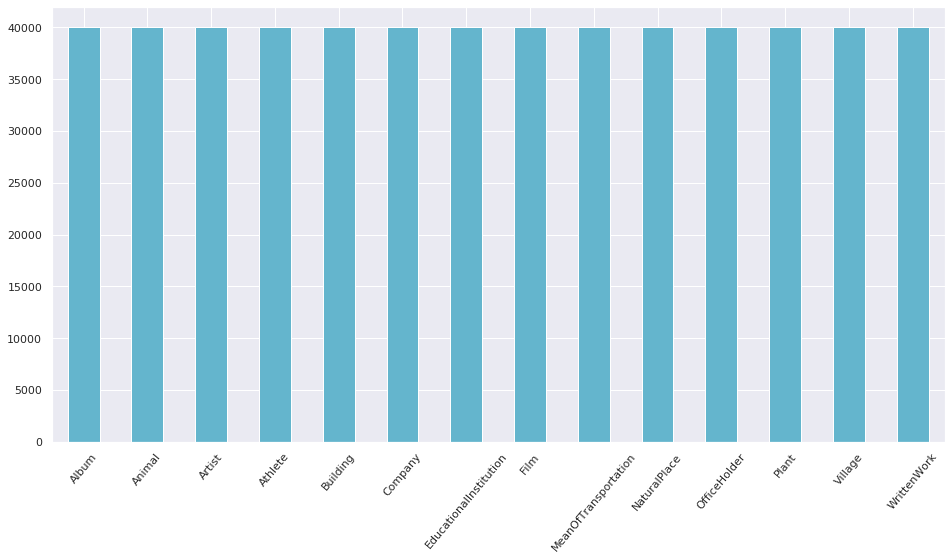

In [23]:
y_train.value_counts().sort_index().plot(kind='bar', figsize=(16, 8), color='c');
plt.xticks(rotation=50);

In [24]:
y_test.nunique()

14

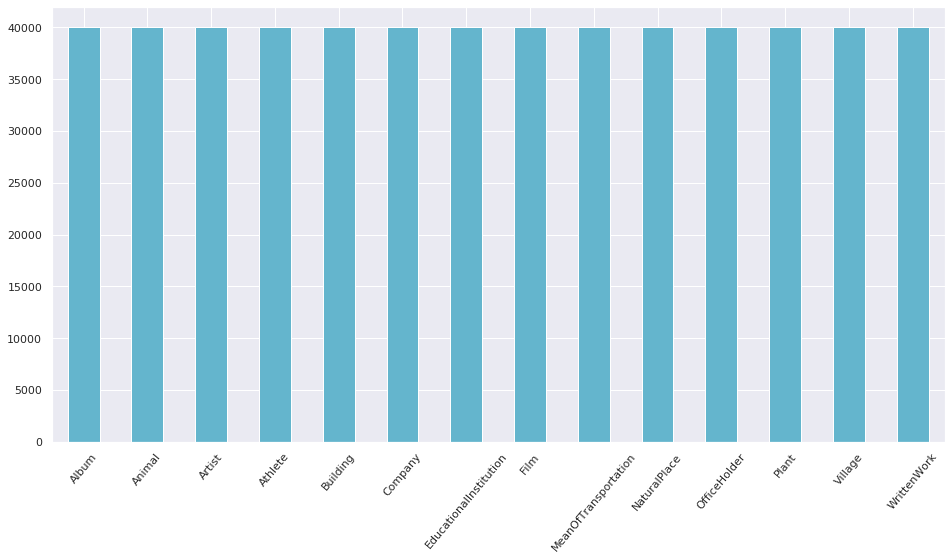

In [25]:
y_test.value_counts().sort_index().plot(kind='bar', figsize=(16, 8), color='c');
plt.xticks(rotation=50);

Os rótulos estão balanceados.

### Analisando a quantidade de caracteres das sentenças:

In [26]:
x_train['len'] = x_train['text'].apply(len)
x_test['len'] = x_test['text'].apply(len)

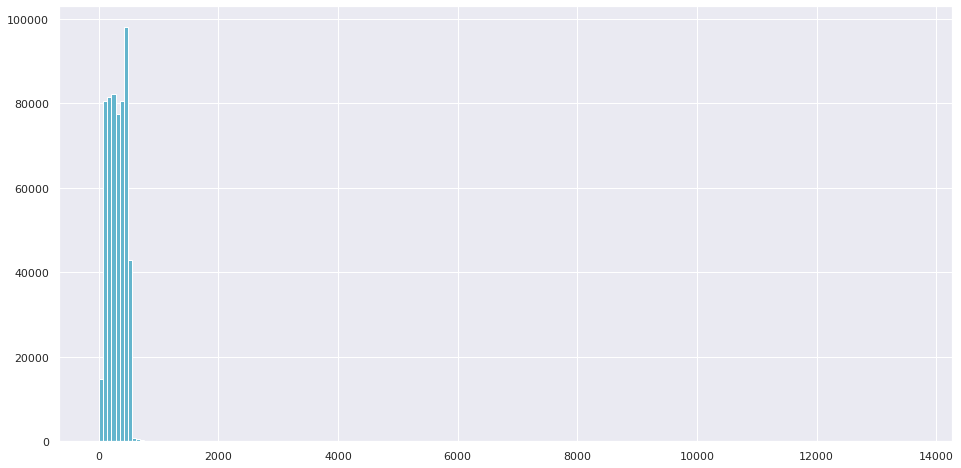

In [29]:
x_train['len'].hist(bins=200, figsize=(16, 8), color='c');

In [28]:
(x_train['len'] > 1000).sum()

186

In [41]:
(x_train['len'] > 10000).sum()

1

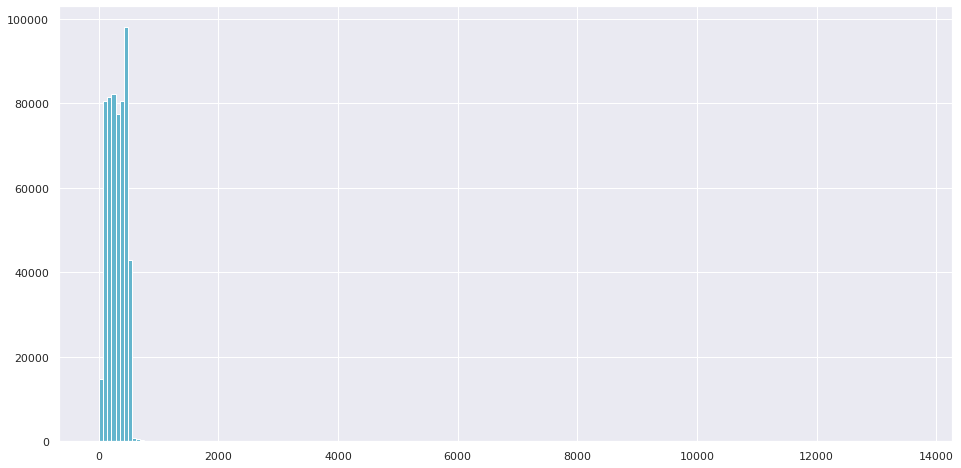

In [42]:
x_test['len'].hist(bins=200, figsize=(16, 8), color='c');

In [43]:
(x_test['len'] > 1000).sum()

186

A distribuição da quantidade de caracteres das setenças é inclinada a esquerda, tendo a maior parte do texto até 1000 caracteres, porém há a presença de sentenças maiores acima de 10000 caracteres.

### Analisando a quantidade de palavras:

In [44]:
x_train['len'] = x_train['text'].apply(lambda x: len(x.split()))
x_test['len'] = x_test['text'].apply(lambda x: len(x.split()))

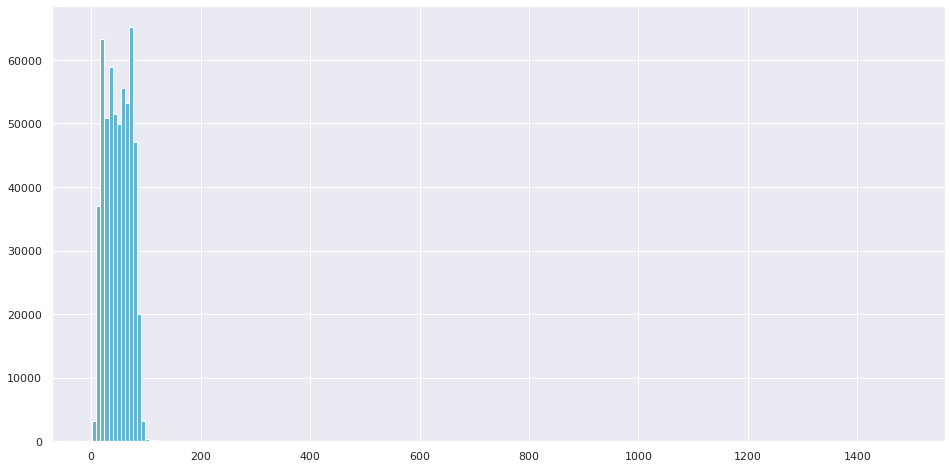

In [48]:
x_train['len'].hist(bins=200, figsize=(16, 8), color='c');

In [49]:
(x_train['len'] > 200).sum()

65

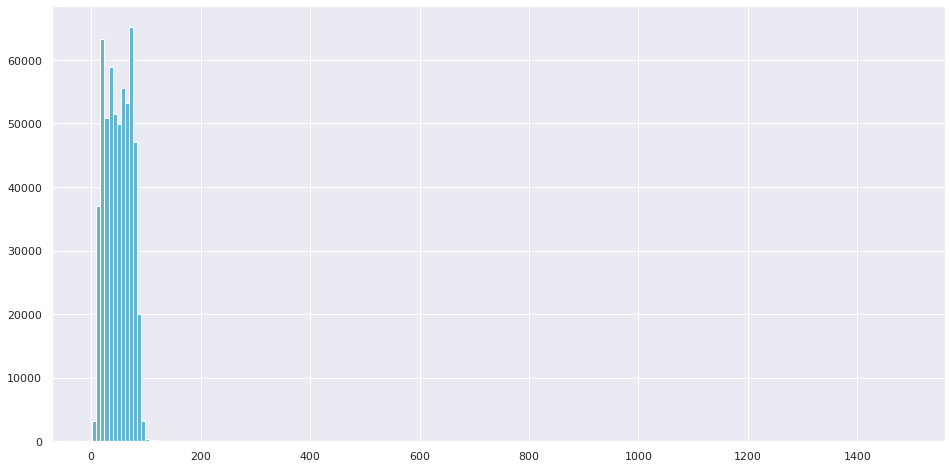

In [50]:
x_test['len'].hist(bins=200, figsize=(16, 8), color='c');

### Analisando a quantidade de palavras únicas:

In [51]:
x_train['len'] = x_train['text'].apply(lambda x: len(set(x.split())))
x_test['len'] = x_test['text'].apply(lambda x: len(set(x.split())))

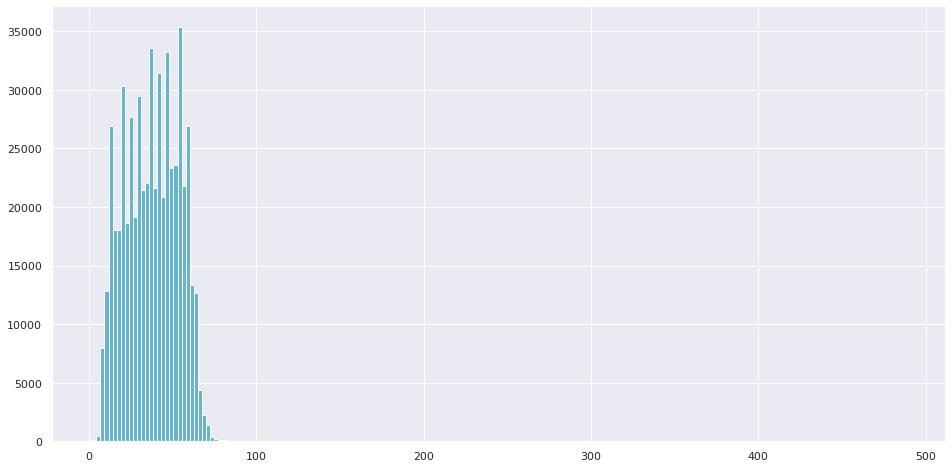

In [53]:
x_train['len'].hist(bins=200, figsize=(16, 8), color='c');

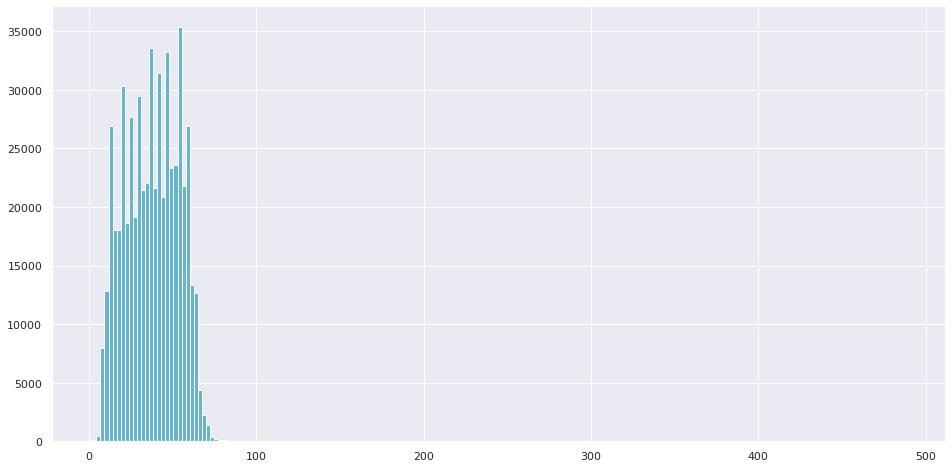

In [54]:
x_test['len'].hist(bins=200, figsize=(16, 8), color='c');

## Plotando as nuvens de palavras:

In [55]:
from wordcloud import WordCloud

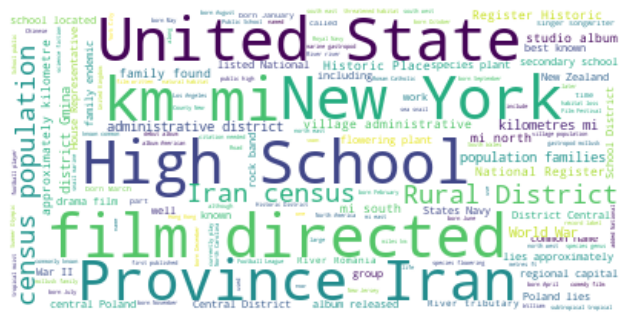

In [56]:
wordcloud = WordCloud(max_font_size=40, max_words=2000, relative_scaling=0, 
                      repeat=False, background_color="white")
wordcloud_geral = wordcloud.generate(' '.join(x_train['text']))

plt.figure(figsize=(11, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

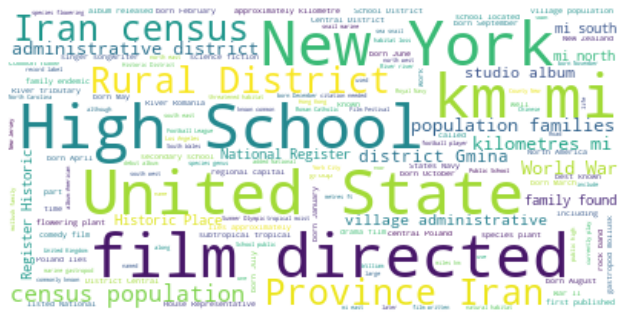

In [57]:
wordcloud = WordCloud(max_font_size=40, max_words=2000, relative_scaling=0, 
                      repeat=False, background_color="white")
wordcloud_geral = wordcloud.generate(' '.join(x_test['text']))

plt.figure(figsize=(11, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Modeling

In [5]:
vectorizer = TfidfVectorizer().fit(x_train['text'])

x_train = vectorizer.transform(x_train['text'])
x_test = vectorizer.transform(x_test['text'])

In [59]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier().fit(x_train, y_train)

y_pred = model.predict(x_test)
print(f'accuracy:  {accuracy_score(y_test, y_pred)}')
print(f'precision: {precision_score(y_test, y_pred, average="weighted")}')
print(f'recall:    {recall_score(y_test, y_pred, average="weighted")}')
print(f'f1_score:  {f1_score(y_test, y_pred, average="weighted")}')

accuracy:  0.8633464285714286
precision: 0.8672601674864518
recall:    0.8633464285714286
f1_score:  0.8620966346434554


In [60]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier().fit(x_train, y_train)

y_pred = model.predict(x_test)
print(f'accuracy:  {accuracy_score(y_test, y_pred)}')
print(f'precision: {precision_score(y_test, y_pred, average="weighted")}')
print(f'recall:    {recall_score(y_test, y_pred, average="weighted")}')
print(f'f1_score:  {f1_score(y_test, y_pred, average="weighted")}')

accuracy:  1.0
precision: 1.0
recall:    1.0
f1_score:  1.0


In [61]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier().fit(x_train, y_train)

y_pred = model.predict(x_test)
print(f'accuracy:  {accuracy_score(y_test, y_pred)}')
print(f'precision: {precision_score(y_test, y_pred, average="weighted")}')
print(f'recall:    {recall_score(y_test, y_pred, average="weighted")}')
print(f'f1_score:  {f1_score(y_test, y_pred, average="weighted")}')

accuracy:  1.0
precision: 1.0
recall:    1.0
f1_score:  1.0


In [62]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier().fit(x_train, y_train)

y_pred = model.predict(x_test)
print(f'accuracy:  {accuracy_score(y_test, y_pred)}')
print(f'precision: {precision_score(y_test, y_pred, average="weighted")}')
print(f'recall:    {recall_score(y_test, y_pred, average="weighted")}')
print(f'f1_score:  {f1_score(y_test, y_pred, average="weighted")}')

accuracy:  0.7846107142857143
precision: 0.8104544652171465
recall:    0.7846107142857143
f1_score:  0.7896975185929092


In [ ]:
# from sklearn.neural_network import MLPClassifier

# model = MLPClassifier().fit(x_train, y_train)

# y_pred = model.predict(x_test)
# print(f'accuracy:  {accuracy_score(y_test, y_pred)}')
# print(f'precision: {precision_score(y_test, y_pred, average="weighted")}')
# print(f'recall:    {recall_score(y_test, y_pred, average="weighted")}')
# print(f'f1_score:  {f1_score(y_test, y_pred, average="weighted")}')

In [ ]:
# from sklearn.svm import SVC
# 
# model = SVC().fit(x_train, y_train)
# 
# y_pred = model.predict(x_test)
# print(f'accuracy:  {accuracy_score(y_test, y_pred)}')
# print(f'precision: {precision_score(y_test, y_pred, average="weighted")}')
# print(f'recall:    {recall_score(y_test, y_pred, average="weighted")}')
# print(f'f1_score:  {f1_score(y_test, y_pred, average="weighted")}')

## Feature importance

In [6]:
mapping_features = {}
for i, feat in enumerate(vectorizer.get_feature_names()):
    mapping_features[i] = feat

In [7]:
x_train.shape[1]

672065

In [8]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier().fit(x_train, y_train)

In [9]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print(f"{f + 1}. {mapping_features[indices[f]]} ({importances[indices[f]]})")
    if importances[indices[f]] == 0.0:
        break

Feature ranking:
1. village (0.06960597615141563)
2. album (0.0650274278036509)
3. film (0.06419544251439938)
4. born (0.050832815140216626)
5. species (0.044591634307147736)
6. school (0.04418492864347061)
7. politician (0.03473130464294028)
8. published (0.03459713891789608)
9. historic (0.029613178700880052)
10. river (0.028782853303315963)
11. company (0.0249023517105112)
12. navy (0.023146826610384464)
13. family (0.019810531708760026)
14. plant (0.017291553078463487)
15. mountain (0.013489818905313868)
16. he (0.012360808454374544)
17. played (0.012277711133403799)
18. built (0.012138629090889225)
19. novel (0.010659393856973377)
20. university (0.010402011177816826)
21. located (0.008487891410689489)
22. lake (0.008461522736111931)
23. of (0.007739551052762379)
24. plays (0.006992383459624334)
25. native (0.006992011851497664)
26. singer (0.006708841744393812)
27. church (0.006665637094652311)
28. college (0.0065964082872449715)
29. by (0.006206875358101879)
30. book (0.00603105

2197. nevada (7.491423984882972e-06)
2198. sell (7.489918582267505e-06)
2199. malmö (7.489541515358776e-06)
2200. kw (7.489470108822219e-06)
2201. 1862 (7.489150430260407e-06)
2202. manager (7.487743972549366e-06)
2203. 1810 (7.487460592062386e-06)
2204. bunchgrass (7.486141470753655e-06)
2205. lotus (7.4844427450179345e-06)
2206. destroyer (7.484062339713139e-06)
2207. milwaukee (7.4826699463327395e-06)
2208. reincarnated (7.4826434979786854e-06)
2209. aimed (7.482627059429783e-06)
2210. fe (7.481752121369083e-06)
2211. mf (7.476749161398275e-06)
2212. subsumed (7.476092106540175e-06)
2213. lined (7.475828196816303e-06)
2214. nonfiction (7.472320558849975e-06)
2215. latvia (7.4715430259279975e-06)
2216. florida (7.4713378041365174e-06)
2217. vines (7.470322893953842e-06)
2218. vessels (7.467641801600523e-06)
2219. regularly (7.464349373143564e-06)
2220. strongly (7.462909312298833e-06)
2221. swamp (7.460469436790089e-06)
2222. glaciers (7.460176087770574e-06)
2223. allen (7.4562720653

4548. hermon (3.808121758866151e-06)
4549. digest (3.808073115003805e-06)
4550. quartet (3.80797895618072e-06)
4551. publicized (3.807952632748322e-06)
4552. yukon (3.8079067118597006e-06)
4553. dyment (3.8078869881534136e-06)
4554. ferrocarril (3.8078863970416525e-06)
4555. bad (3.8078626799556906e-06)
4556. 5th (3.807813891125211e-06)
4557. nathan (3.8078135832254044e-06)
4558. kushner (3.8077454262764167e-06)
4559. packs (3.807656886760998e-06)
4560. magicians (3.807487172081936e-06)
4561. discipline (3.807424790234961e-06)
4562. img (3.807412955988699e-06)
4563. dozens (3.8073833058210172e-06)
4564. twickenham (3.807380114680387e-06)
4565. s1 (3.8073727029126954e-06)
4566. andu (3.807359588534189e-06)
4567. pubipalmatum (3.807347557347565e-06)
4568. display (3.8073066400901462e-06)
4569. isbn (3.807303807303799e-06)
4570. すーぱーそに子 (3.8072711181748907e-06)
4571. kincardine (3.8072488788112e-06)
4572. mccann (3.8072307045788383e-06)
4573. yìngtái (3.807213473299734e-06)
4574. arboresc

6724. lawrason (2.884615384615384e-06)
6725. delayed (2.884615384615384e-06)
6726. reporting (2.884615384615384e-06)
6727. stickhausen (2.884615384615384e-06)
6728. cain (2.884615384615384e-06)
6729. pooviyoor (2.884615384615384e-06)
6730. silberman (2.884615384615384e-06)
6731. sasayama (2.884615384615384e-06)
6732. antão (2.884615384615384e-06)
6733. extimalis (2.884615384615384e-06)
6734. ecology (2.884615384615384e-06)
6735. juludia (2.884615384615384e-06)
6736. outlet (2.884615384615384e-06)
6737. communist (2.884615384615384e-06)
6738. jason (2.884615384615384e-06)
6739. socio (2.884615384615384e-06)
6740. jasdanwalla (2.884615384615384e-06)
6741. 1914 (2.884615384615384e-06)
6742. 5000 (2.884615384615384e-06)
6743. niffenegger (2.884615384615384e-06)
6744. camposaurus (2.884615384615384e-06)
6745. abey (2.884615384615384e-06)
6746. youngest (2.884615384615384e-06)
6747. either (2.884615384615384e-06)
6748. legoland (2.884615384615384e-06)
6749. amusement (2.884615384615384e-06)
